# CARGA DE DATOS

In [1]:
from Utils import DatasetProcess, reconstruction_plot, anomaly_report
from ConvModel import ConvModel
from AutoEncoder import TwoStepAutoEncoder, TwoStepClassifier, TwoStepTraining, OneStepAutoencoder, OneStepTraining
from OneClass import AnomalyDetector
from Contrastive import ContrastiveModel

In [ ]:
(x_train, y_train), (x_test, y_test) = DatasetProcess.load()


# Aplicar la función hold_out
(x_train_no_labeled, x_train_labeled, y_train_labeled), (x_val, y_val), (x_test, y_test) = DatasetProcess.hold_out(
    (x_train, y_train), (x_test, y_test), validation_size=1000
)

x_train_labeled = x_train_labeled.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Verificar las dimensiones
print(f"Datos no etiquetados: {x_train_no_labeled.shape}")
print(f"Datos etiquetados entrenamiento: {x_train_labeled.shape}")
print(f"Etiquetas entrenamiento: {y_train_labeled.shape}")
print(f"Datos validación: {x_val.shape}")
print(f"Etiquetas validación: {y_val.shape}")
print(f"Datos prueba: {x_test.shape}")
print(f"Etiquetas prueba: {y_test.shape}")

# EJERCICIO 1

Entrena un modelo, creado sobre TensorFlow, haciendo uso únicamente de las instancias etiquetadas de entrenamiento. Dicho modelo debe de tener al menos cuatro capas densas y/o convolucionales.

Responde a las siguientes preguntas:

1. ¿Qué red has escogido? ¿Por qué? ¿Cómo la has entrenado?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Qué conclusiones sacas de los resultados detallados en el punto anterior?

In [ ]:
model_base = ConvModel()
history_base = model_base.fit(
    x_train_labeled, 
    y_train_labeled,
    validation_data=(x_val, y_val),
    batch_size=128,
    epochs=100
)

In [ ]:
# Evalúa con el conjunto de prueba
test_accuracy = model_base.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba: {test_accuracy}")

model_base.plot(history_base)

# EJERCICIO 2

Entrena el mismo modelo, incorporando las instancias no etiquetadas de entrenamiento mediante la técnica de auto-aprendizaje. Opcionalmente, se ponderará cada instancia de entrada en función de su calidad (o certeza).

Responde a las siguientes preguntas:
1. ¿Qué parámetros has definido para el entrenamiento?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en el Ejercicio 1?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [ ]:
# Función para crear modelos consistentes durante self-training
def create_model():
    return ConvModel(
        learning_rate=0.0005,  # Learning rate reducido para fine-tuning
        dropout_prob=0.25,     
        l2_lambda=0.005        
    )

# Normalizar datos no etiquetados
x_train_no_labeled = x_train_no_labeled.astype('float32') / 255.0

# Aplica self-training con datos no etiquetados
final_model = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train_labeled,
    y_train=y_train_labeled,  
    unlabeled_data=x_train_no_labeled,
    validation_data=(x_val, y_val),
    thresh=0.8,             
    train_epochs=5,
    verbose=1
)

# Evalúa el modelo final
final_accuracy = final_model.score(x_test, y_test)
print(f"Accuracy del modelo final con self-training: {final_accuracy}")
print(f"Mejora respecto al modelo base: {final_accuracy - test_accuracy:.4f}")

# EJERCICIO 3

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en dos pasos (primero el autoencoder, después el clasificador). La arquitectura del encoder debe ser exactamente la misma que la definida en los Ejercicios 1 y 2, a excepción del último bloque de capas.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los Ejercicios 1 y 2?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [2]:
unlabeled_train, x_train, y_train, x_val, y_val, x_test, y_test, one_hot_train, one_hot_val, one_hot_test = DatasetProcess.alt()

In [4]:
autoencoder = TwoStepAutoEncoder(
                                input_shape=unlabeled_train[0].shape,
                                learning_rate=0.006,
                                l2_lambda=0.0005,
                                dropout_prob=0.1)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)


In [ ]:
TwoStepTraining(autoencoder=autoencoder, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=405)

In [ ]:
reconstruction_plot(autoencoder, x_test)

In [ ]:
autoencoder.score(x_test)

# EJERCICIO 4

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en un paso (autoencoder y clasificador al mismo tiempo). La arquitectura del autoencoder será la misma que la definida en el Ejercicio 3, y la combinación de encoder y clasificador será igual a la arquitectura definida en el
Ejercicio 1.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los ejercicios anteriores?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [7]:
one_step_autoencoder = OneStepAutoencoder(input_shape=unlabeled_train[0].shape,
                                learning_rate=0.0015,
                                decoder_extra_loss_weight = 0.45,
                                l2_lambda=0.00005,
                                dropout_prob=0.05)

In [8]:
h = OneStepTraining(one_step_autoencoder, 
                    x_train=x_train, 
                    y_train=one_hot_train, 
                    unlabeled_train=unlabeled_train,
                    batch_size=512,
                    epochs=1,
                    patience=10)

82/82 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - classifier_accuracy: 0.0207 - classifier_loss: 0.9045 - decoder_loss: 0.0664 - loss: 0.7053


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


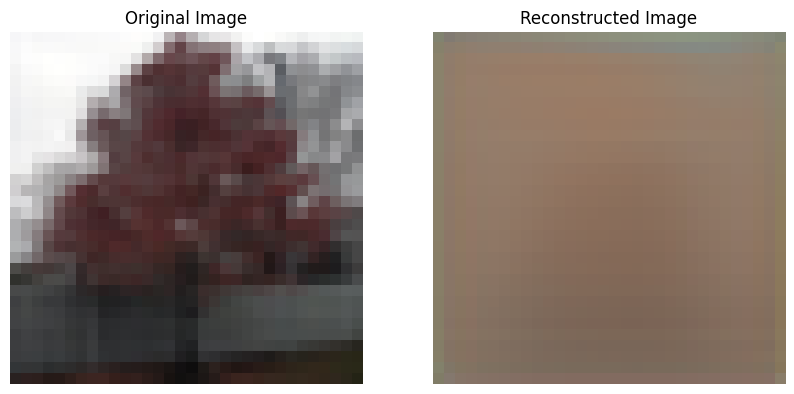

In [9]:
reconstruction_plot(one_step_autoencoder, x_test)

In [10]:
one_step_autoencoder.score(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


0.0189

In [29]:
y_pred

array([7747, 2410, 7747, 2973, 6825, 6047, 7747, 7776, 7971, 7747, 5622,
       5622, 3065, 2410, 2824, 2238, 7261, 3432,  819, 7747,  312, 8614,
       1642, 8428, 7458, 2274, 7747, 8111, 3572, 6825, 3221, 2238, 1304,
        178, 7747, 7747, 7901, 4657, 7007, 3572,  908, 3065, 3311, 6047,
       1682, 7747, 5622,  672, 5622, 3221, 3512, 7747, 4805, 7747, 2410,
       4643, 2824, 7747, 7747, 4805, 8521, 7901, 2410,  524,  519, 4966,
       2410,  276, 8521, 3872, 5622, 8428, 3065, 9782, 8399, 8614, 7318,
       5558, 7747,  819, 7989,   22, 2627, 7747,  519,  524, 4951, 3227,
       7747,  524, 5891, 9524, 2410, 4809, 2274,  276,  672,  166, 7747,
       4809])

# EJERCICIO 5

Repite el mismo entrenamiento de los Ejercicios 1-4, pero eliminando las instancias no etiquetadas
más atípicas con respecto a los datos etiquetados. Se cumplirán los siguientes puntos:
- La arquitectura de la red de clasificación en una clase será la misma a la utilizada en el
clasificador del Ejercicio 1, a excepción de la capa de salida.
- Utiliza la técnica explicada en el Notebook 5, usando un valor de 𝑣 = 0,9.

Responde a la siguiente pregunta:
1. ¿Se mejoran los resultados con respecto a los anteriores ejercicios? ¿Qué conclusiones sacas de estos resultados?

In [4]:
model = AnomalyDetector(input_shape=(32,32,3), 
                        nu=.9,
                        l2_lambda=0.0,
                        learning_rate=0.0001,
                        dropout_prob=0.0)
model.fit(x_train, 
          batch_size=256, 
          epochs=50, 
          delta=.025, 
          steps=100)

/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step- loss: 0.3976 
Cambiando r a 0.68941 , max: 0.7030964 , min: 0.6856215
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 631ms/step - loss: 0.3957
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step- loss: 0.0896 
Cambiando r a 0.6929456 , max: 0.7051185 , min: 0.6809733
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 603ms/step - loss: 0.0893
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step- loss: 0.0607 
Cambiando r a 0.7655051 , max: 0.7815761 , min: 0.7528915
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - loss: 0.0607
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step- loss: 0.0702 
Cambiando r a 0.7517379 , max: 0.7745997 , min: 0.74289966
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - loss: 0.0704
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step- loss: 0.0710 
Cambiando r a 0.7868839 , max: 0.8291261 , min: 0.7616805
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 756ms/step - loss: 0.0707
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step- loss: 0.0646 
Cambiando r a 0.74

<Sequential name=sequential_1, built=True>

# DE AQUI HASTA EL 6 LO QUE PUSE

In [ ]:
filtered_unlabeled_train = anomaly_report(model, unlabeled_train)

In [15]:

# Primero predecimos qué datos son típicos en el conjunto no etiquetado
unlabeled_predictions = model.predict(unlabeled_train)
r_value = model.model.r.numpy()
is_typical = unlabeled_predictions > r_value

# Filtramos para obtener solo los datos típicos
filtered_unlabeled_train = [unlabeled_train[i]  for i in range(len(unlabeled_train)) if is_typical[i]]
percetage = float(sum(is_typical) * 100 / len(is_typical))
print(f"Porcentaje de datos no etiquetados etiquetados como típicos: {percetage:.2f}%")
print(f"Porcentaje de datos no etiquetados etiquetados como atípicos: {100 - percetage:.2f}%")
print(f"Datos originales no etiquetados: {unlabeled_train.shape}")
print(f"Datos filtrados no etiquetados (solo típicos): {filtered_unlabeled_train.shape}")
print(f"Se eliminaron {unlabeled_train.shape[0] - filtered_unlabeled_train.shape[0]} muestras atípicas")

1047/1047 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step
Porcentaje de datos no etiquetados etiquetados como típicos: 89.32%
Porcentaje de datos no etiquetados etiquetados como atípicos: 10.68%
Datos originales no etiquetados: (33500, 32, 32, 3)


/var/folders/1l/sdrz_tw104ld922_w0xnl5840000gn/T/ipykernel_94029/1206633462.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  percetage = float(sum(is_typical) * 100 / len(is_typical))


AttributeError: 'list' object has no attribute 'shape'

In [9]:
unlabeled_predictions.shape

(33500, 1)

In [ ]:
# Ahora entrenamos los modelos con los datos filtrados

# Ejercicio 2 con datos filtrados
model_self_filtered = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train_labeled,
    y_train=y_train_labeled,
    unlabeled_data=filtered_unlabeled_train,
    validation_data=(x_val, y_val),
    thresh=0.8,
    train_epochs=5
)

# Evaluar los modelos filtrados
test_accuracy_self_filtered = model_self_filtered.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba (self-training filtrado): {test_accuracy_self_filtered}")

In [ ]:
# Ejercicio 3 con datos filtrados
autoencoder_filtered = TwoStepAutoEncoder(
    input_shape=filtered_unlabeled_train[0].shape,
    learning_rate=0.006,
    l2_lambda=0.0005,
    dropout_prob=0.1
)

classifier_filtered = TwoStepClassifier(
    l2_lambda=0.0005,
    dropout_prob=0.05,
    learning_rate=0.05
)

history_two_step_filtered = TwoStepTraining(
    autoencoder=autoencoder_filtered, 
    classifier=classifier_filtered, 
    x_train=x_train, 
    y_train=one_hot_train, 
    unlabeled_train=filtered_unlabeled_train, 
    validation_data=(x_val, one_hot_val),
    batch_size_autoencoder=256,
    epochs_autoencoder=50,
    batch_size_classifier=256,
    epochs_classifier=100
)

# Evaluar modelos
test_accuracy_two_step_filtered = classifier_filtered.score(x_test, y_test)  # No se si es asi como se evaluaria este la verdad supongo que si
print(f"Accuracy del modelo one-step filtrado: {test_accuracy_two_step_filtered}")

In [ ]:
# Ejercicio 4 con datos filtrados
one_step_autoencoder_filtered = OneStepAutoencoder(
    input_shape=filtered_unlabeled_train[0].shape,
    learning_rate=0.0015,
    decoder_extra_loss_weight=0.45,
    l2_lambda=0.00005,
    dropout_prob=0.05
)

history_one_step_filtered = OneStepTraining(
    one_step_autoencoder_filtered, 
    x_train=x_train, 
    y_train=one_hot_train, 
    unlabeled_train=filtered_unlabeled_train,
    batch_size=256,
    epochs=100,
    patience=10
)
# Evaluar modelos
test_accuracy_one_step_filtered = one_step_autoencoder_filtered.score(x_test, y_test)
print(f"Accuracy del modelo one-step filtrado: {test_accuracy_one_step_filtered}")

# EJERCICIO 6

Repite los Ejercicios 3-5 cambiando el autencoder por la técnica definida en el apartado “Hay vida más allá del autoencoder” del Notebook 4. Contesta a las preguntas de dichos ejercicios. Se cumplirán los siguientes puntos:

1. La arquitectura de la red será igual a la parte encoder del autencoder definido en los
ejercicios anteriores.
2. El modelo debe entrenar correctamente.

...................................................................................................................................Epoch 1/5, Total Loss: 5.3884, Contrastive Loss: 5.2545, Clustering Loss: 0.1488
..................................................................................................................................Epoch 2/5, Total Loss: 4.8257, Contrastive Loss: 4.8257, Clustering Loss: 0.0000
..................................................................................................................................Epoch 3/5, Total Loss: 4.6164, Contrastive Loss: 4.6164, Clustering Loss: 0.0000
..................................................................................................................................Epoch 4/5, Total Loss: 4.5598, Contrastive Loss: 4.5598, Clustering Loss: 0.0000
..................................................................................................................................Epoch 5/5, Total Loss: 4.

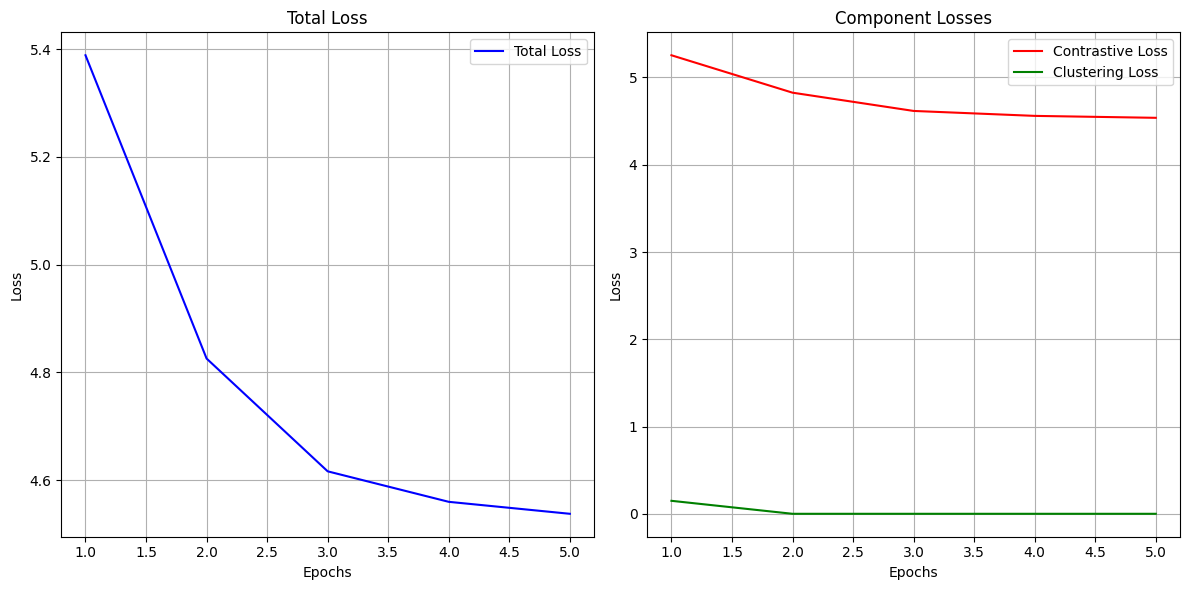

In [6]:
cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001,
                          dropout_prob=0.001)
cModel.train(unlabeled_train, 
             epochs=5, 
             batch_size= 256)
cModel.plot_training_history()

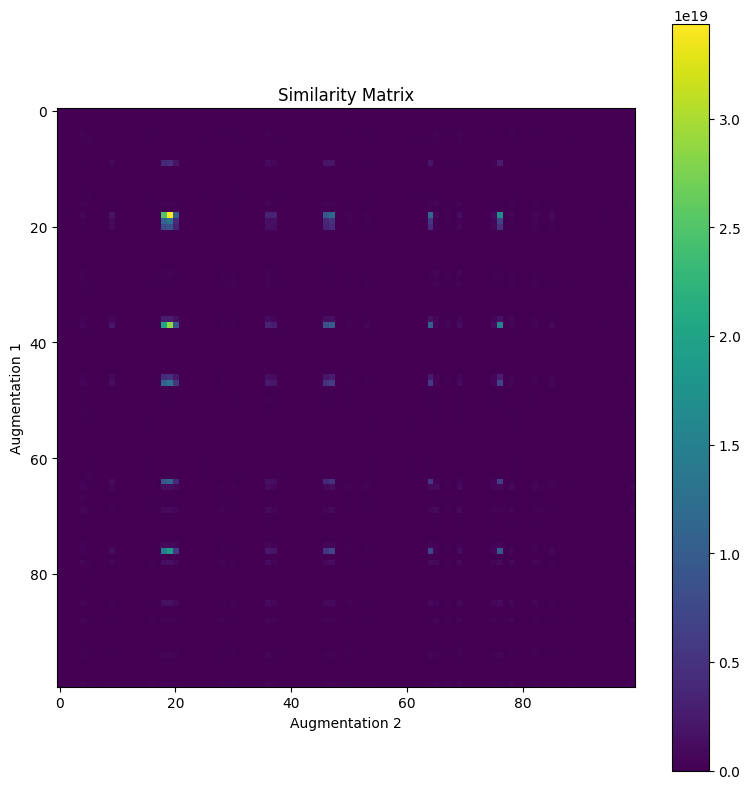

In [7]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cModel.plot_similarity_matrix(test_samples, n_samples=n_samples);

# Echale un vistazo q no se como ira

In [ ]:
# Ejercicio 6 - Implementación con técnica contrastiva

# Primero filtrar datos atípicos 
unlabeled_predictions = model.predict(unlabeled_train)
r_value = model.model.r.numpy()
is_typical = unlabeled_predictions > r_value
filtered_unlabeled_train = unlabeled_train[is_typical]

# Entrenar modelo contrastivo con datos completos
contrastive_full = ContrastiveModel(
    unlabeled_train[0].shape, 
    learning_rate=0.05, 
    lambda_param=0.9,
    l2_lambda=0.001
)
contrastive_full.train(
    unlabeled_train, 
    epochs=5, 
    batch_size=2048
)

# Entrenar modelo contrastivo con datos filtrados
contrastive_filtered = ContrastiveModel(
    filtered_unlabeled_train[0].shape, 
    learning_rate=0.05, 
    lambda_param=0.9,
    l2_lambda=0.001
)
contrastive_filtered.train(
    filtered_unlabeled_train, 
    epochs=5, 
    batch_size=2048
)

# Extraer características para clasificación
train_features_full = contrastive_full.get_features(x_train)
val_features_full = contrastive_full.get_features(x_val)
test_features_full = contrastive_full.get_features(x_test)

train_features_filtered = contrastive_filtered.get_features(x_train)
val_features_filtered = contrastive_filtered.get_features(x_val)
test_features_filtered = contrastive_filtered.get_features(x_test)

# Entrenar clasificadores con estas características
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Clasificador para características del modelo contrastivo completo
classifier_contrastive_full = Sequential([
    Dense(128, activation='relu', input_shape=(train_features_full.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

classifier_contrastive_full.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_clf_full = classifier_contrastive_full.fit(
    train_features_full, one_hot_train,
    validation_data=(val_features_full, one_hot_val),
    epochs=50,
    batch_size=256,
    verbose=1
)

# Clasificador para características del modelo contrastivo filtrado
classifier_contrastive_filtered = Sequential([
    Dense(128, activation='relu', input_shape=(train_features_filtered.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

classifier_contrastive_filtered.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_clf_filtered = classifier_contrastive_filtered.fit(
    train_features_filtered, one_hot_train,
    validation_data=(val_features_filtered, one_hot_val),
    epochs=50,
    batch_size=256,
    verbose=1
)

# Evaluar modelos
test_loss_full, test_acc_full = classifier_contrastive_full.evaluate(test_features_full, one_hot_test)
test_loss_filtered, test_acc_filtered = classifier_contrastive_filtered.evaluate(test_features_filtered, one_hot_test)

print(f"Accuracy del clasificador contrastivo completo: {test_acc_full}")
print(f"Accuracy del clasificador contrastivo filtrado: {test_acc_filtered}")

# Visualizar matrices de similitud para ambos modelos
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples, 32, 32, 3)

import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
contrastive_full.plot_similarity_matrix(test_samples, n_samples=n_samples)
plt.title("Matriz de similitud - Modelo contrastivo con datos completos")

plt.subplot(1, 2, 2)
contrastive_filtered.plot_similarity_matrix(test_samples, n_samples=n_samples)
plt.title("Matriz de similitud - Modelo contrastivo con datos filtrados")

plt.tight_layout()
plt.show()